In [1]:
import os
import sys
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import random
import time

sys.path.insert(1, '//workspace/dl2020')
#from model_loader_CP2 import *
from CP_helper_RCNN import *
from data_helper_RCNN import *
#from Unet import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data

#from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

%load_ext autoreload
%autoreload 2
%load_ext autotime



In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

time: 1.72 ms


In [3]:
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

time: 727 µs


In [4]:
labeled_scene_index_shuf = labeled_scene_index
random.shuffle(labeled_scene_index_shuf)
train_labeled_scene_index = labeled_scene_index_shuf[:-10]
val_labeled_scene_index = labeled_scene_index_shuf[-10: 0 ]

time: 1.29 ms


In [5]:
# check RCNN dataset
kwargs = {
    #'first_dim': 'sample',
    'transform': transforms.ToTensor(),
    'image_folder': image_folder,
    'annotation_file': annotation_csv,
    'extra_info': True}


dataset_train = LabeledDataset_RCNN (scene_index=train_labeled_scene_index, **kwargs)

time: 164 ms


In [6]:
len(dataset_train)

2268

time: 4.06 ms


In [7]:
train_data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

time: 1.05 ms


In [8]:
img = None
tg = None
for i ,(image, target) in enumerate(train_data_loader):
    img = image
    tg = target
    break

time: 541 ms


In [9]:
img

(tensor([[[0.0941, 0.0980, 0.1059,  ..., 0.4392, 0.4353, 0.4314],
          [0.0941, 0.0980, 0.1059,  ..., 0.4314, 0.4235, 0.4157],
          [0.0941, 0.1020, 0.1059,  ..., 0.4235, 0.4078, 0.4000],
          ...,
          [0.8471, 0.8706, 0.9020,  ..., 1.0000, 1.0000, 1.0000],
          [0.8275, 0.8549, 0.8863,  ..., 1.0000, 1.0000, 1.0000],
          [0.8157, 0.8471, 0.8784,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.3569, 0.3608, 0.3686,  ..., 0.2627, 0.2588, 0.2549],
          [0.3569, 0.3608, 0.3686,  ..., 0.2549, 0.2471, 0.2392],
          [0.3569, 0.3647, 0.3686,  ..., 0.2471, 0.2314, 0.2235],
          ...,
          [0.9725, 0.9882, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9647, 0.9804, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
          [0.9608, 0.9725, 0.9882,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.8157, 0.8196, 0.8275,  ..., 0.2627, 0.2588, 0.2549],
          [0.8157, 0.8196, 0.8275,  ..., 0.2549, 0.2471, 0.2392],
          [0.8157, 0.8235, 0.8275,  ...,

time: 5.47 ms


In [11]:
toImg = transforms.ToPILImage()
img_ = toImg(img[0])

time: 38.2 ms


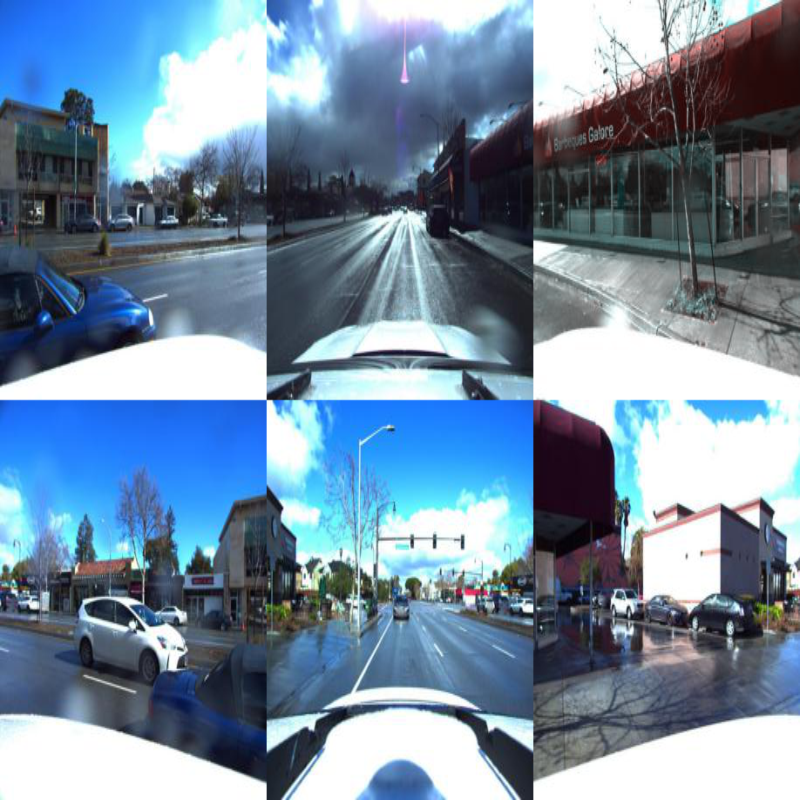

time: 237 ms


In [12]:
img_

In [13]:
tg

({'boxes': tensor([[ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
          [ 10.7961, 224.3112, 777.9437, 673.3602],
   

time: 7.44 ms


In [24]:
num_obj = 3
img_w = 10
img_h=10
masks = torch.zeros((num_obj, img_w, img_h))

time: 1.38 ms


In [26]:
masks

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.,

time: 3.81 ms


In [28]:
masks[1, 2:8, 1:4] = 4

time: 1.1 ms


In [29]:
masks

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 4., 4., 4., 0., 0., 0., 0., 0., 0.],
         [0., 4., 4., 4., 0., 0., 0., 0., 0., 0.],
         [0., 4., 4., 4., 0., 0., 0., 0., 0., 0.],
         [0., 4., 4., 4., 0., 0., 0., 0., 0., 0.],
         [0., 4., 4., 4., 0., 0., 0., 0., 0., 0.],
         [0., 4., 4., 4., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.,

time: 5 ms
